# Importing Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf

In [2]:
test = tf.data.Dataset.load('split_tensor/test_ds/')
test_arr = np.array(list(test.as_numpy_iterator()))
masks = test_arr[:,1,:,:,:]
images = test_arr[:,0,:,:,:]

### Creating dictionary from numpy

In [3]:

entropy_models = np.load('Uncertainty_comparison/entropy_models_f.npy', allow_pickle=True)
preds_models = np.load('Uncertainty_comparison/preds_models_f.npy', allow_pickle=True)

entropy = {}
for i in range(len(entropy_models)):
    model_name = entropy_models[i][0]
    entropy[model_name] = {'entropy_all': entropy_models[i][1],
                        'entropy_gland':entropy_models[i][2],
                        'entropy_cz':entropy_models[i][3],
                        'entropy_pz':entropy_models[i][4],
                        'entropy_tz':entropy_models[i][5],
                        'entropy_tum':entropy_models[i][6]}

preds = {}
for j in range(len(preds_models)):
    model_name = preds_models[j][0]
    preds[model_name] = {'test_argmax_all': preds_models[j][1],
                        'test_argmax_gland':preds_models[j][2],
                        'test_cz':preds_models[j][3],
                        'test_pz':preds_models[j][4],
                        'test_tz':preds_models[j][5],
                        'test_tum':preds_models[j][6]}

list(preds.keys())

['unet',
 'r2unet',
 'attr2unet',
 'swinunet',
 'denseunet',
 'faunet',
 'attunet',
 'attdenseunet']

In [4]:
normalized_entropy = {}
for name in list(entropy.keys()):
    norm_entropy_zones = []
    for zone in list(entropy[name].keys()):
        # print(zone)
        norm_entropy_temp = []
        for i in range(len(entropy[name][zone])):
            min_entropy = np.min(entropy[name][zone][i])
            max_entropy = np.max(entropy[name][zone][i])
            norm_entropy = [(x - min_entropy) / (max_entropy - min_entropy) for x in (entropy[name][zone][i])]  #one normalized image
            norm_entropy_temp.append(norm_entropy)              
        norm_entropy_temp = np.array(norm_entropy_temp)         # All images for one zone
        # print(norm_entropy_temp.shape)      #(31,256,256)
        norm_entropy_zones.append(norm_entropy_temp)        # All images for one zone
    norm_entropy_zones = np.array(norm_entropy_zones)      # All zones
    # print(norm_entropy_zones.shape)
    normalized_entropy[name] = {'entropy_all': norm_entropy_zones[0],
                                'entropy_gland':norm_entropy_zones[1],
                                'entropy_cz':norm_entropy_zones[2],
                                'entropy_pz':norm_entropy_zones[3],
                                'entropy_tz':norm_entropy_zones[4],
                                'entropy_tum':norm_entropy_zones[5]}


normalized_entropy.keys()


dict_keys(['unet', 'r2unet', 'attr2unet', 'swinunet', 'denseunet', 'faunet', 'attunet', 'attdenseunet'])

### Selecting images for plot

In [5]:
lst4 = []
lst3 = []
lst3t = []
lst2 = []
for i in range(len(masks)):
    if (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (3 in masks[i]) and (4 in masks[i]):
        lst4.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (3 in masks[i]):
        lst3.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]) and (4 in masks[i]):
        lst3t.append(i)
    elif (0 in masks[i]) and (1 in masks[i]) and (2 in masks[i]):
        lst2.append(i)

print('Lista 4: ', lst4)
print('Lista 3: ', lst3)
print('Lista 3tumor: ', lst3t)
print('Lista 2: ', lst2)


Lista 4:  [3, 6, 7, 19, 27, 29]
Lista 3:  [1, 2, 5, 11, 13, 15, 18, 20, 22, 26]
Lista 3tumor:  [4, 8, 17, 23]
Lista 2:  [0, 9, 10, 12, 14, 16, 21, 24, 25, 28, 30]


In [6]:
# Selecting images
# z2 = 14
z2 = 0
z3 = 18
# z3 = 5
z3t = 17
# z3t =  8
z4 = 3
# z4 = 6

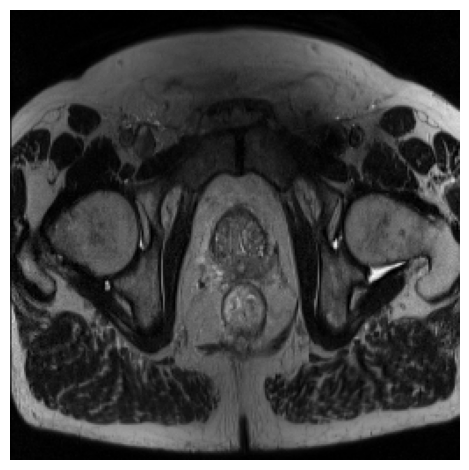

In [6]:
plt.imshow(images[3], cmap='gray')
plt.axis('off')
plt.tight_layout()
# plt.savefig('tumor.png', dpi=300)

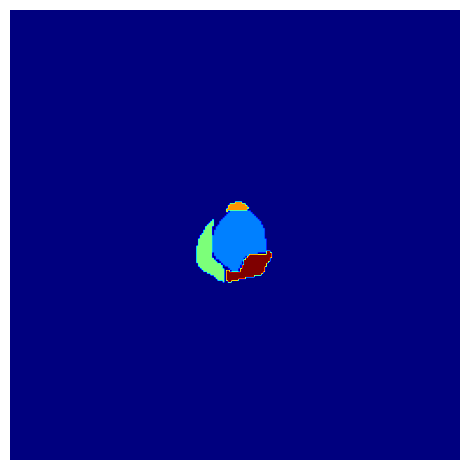

In [7]:
import matplotlib.patches as mpatches
import matplotlib
# color= matplotlib.colors.LinearSegmentedColormap.from_list("", ['black', 'royalblue', 'limegreen', 'orange', 'tomato'])
im = plt.imshow(masks[3], cmap='jet', vmin=0, vmax=4)
plt.axis('off')
plt.tight_layout()
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]

# Plots

## Crop and resize

In [7]:
from functools import reduce
from skimage.transform import resize
start_idx = 256//3
end_idx = 2 * (256//3)

dict_imgs = {}
dict_msks = {}
dict_preds = {}
dict_entropy = {}

names_model = list(preds.keys())
idx = [z2, z3, z3t, z4]
for i in idx:
    cropped_img = images[i][start_idx:end_idx, start_idx:end_idx, :]
    dict_imgs[i] = resize(cropped_img, (256, 256), anti_aliasing=True)
    cropped_msk = masks[i][start_idx:end_idx, start_idx:end_idx, :]
    dict_msks[i] = resize(cropped_msk, (256, 256), anti_aliasing=True)
    entropy_list = []
    preds_list = []
    for j in names_model:
        cropped_ent= normalized_entropy[j]['entropy_all'][i][start_idx:end_idx, start_idx:end_idx]
        cropped_ent = resize(cropped_ent, (256, 256), anti_aliasing=False)
        cropped_pred= preds[j]['test_argmax_all'][i][start_idx:end_idx, start_idx:end_idx]
        # cropped_pred = np.repeat(np.repeat(cropped_pred, 2, axis=0), 2, axis=1)
        entropy_list.append({j:cropped_ent})
        preds_list.append({j:cropped_pred})
    dict_entropy[i] = reduce(lambda a, b: {**a, **b}, entropy_list)
    dict_preds[i] = reduce(lambda a, b: {**a, **b}, preds_list)


Crop for all images

In [8]:
from functools import reduce
from skimage.transform import resize
start_idx = 256//3
end_idx = 2 * (256//3)

dict_imgs = {}
dict_msks = {}
dict_preds = {}
dict_entropy = {}

names_model = list(preds.keys())

for j in names_model:
    entropy_dict = {}
    preds_list = []
    for i in range(len(images)):
        cropped_img = images[i][start_idx:end_idx, start_idx:end_idx, :]
        dict_imgs[i] = resize(cropped_img, (256, 256), anti_aliasing=True)
        cropped_msk = masks[i][start_idx:end_idx, start_idx:end_idx, :]
        dict_msks[i] = resize(cropped_msk, (256, 256), anti_aliasing=True)
        cropped_pred= preds[j]['test_argmax_all'][i][start_idx:end_idx, start_idx:end_idx]
        # cropped_pred = resize(cropped_pred, (256, 256), anti_aliasing=True)
        
        # for k in list(normalized_entropy[j].keys()):
        #     cropped_ent = normalized_entropy[j][k][i][start_idx:end_idx, start_idx:end_idx]
        #     cropped_ent = resize(cropped_ent, (256, 256), anti_aliasing=False)
        #     entropy_dict[k] = cropped_ent


        preds_list.append(cropped_pred)
    preds_list = np.array(preds_list)
    
    # dict_entropy[j] = entropy_dict
    dict_preds[j] = preds_list




for name in (names_model):
    zones_full = []
    for zone in list(normalized_entropy[name].keys()):
        zone_temp = []
        for i in range(len(normalized_entropy[name][zone])):
            cropped_ent = normalized_entropy[name][zone][i][start_idx:end_idx, start_idx:end_idx]
            cropped_ent = resize(cropped_ent, (256, 256), anti_aliasing=False)
            zone_temp.append(cropped_ent)
        zone_temp = np.array(zone_temp)
        
        zones_full.append(zone_temp)        # All images for one zone
    zones_full = np.array(zones_full)      # All zones
    dict_entropy[name] = {'entropy_all': zones_full[0],
                                'entropy_gland':zones_full[1],
                                'entropy_cz':zones_full[2],
                                'entropy_pz':zones_full[3],
                                'entropy_tz':zones_full[4],
                                'entropy_tum':zones_full[5]}


dict_entropy.keys()





dict_keys(['unet', 'r2unet', 'attr2unet', 'swinunet', 'denseunet', 'faunet', 'attunet', 'attdenseunet'])

In [9]:
dict_entropy['unet']['entropy_all'].shape

(31, 256, 256)

In [10]:
dict_preds['unet'].shape

(31, 85, 85)

## Uncertainty subplot

In [11]:
# Selecting images
z2 = 14
# z2 = 0
z3 = 18
# z3 = 5
# z3t = 17
z3t =  8
# z4 = 3
z4 = 3
#[3, 6, 7, 19, 27, 29]

### Vertical

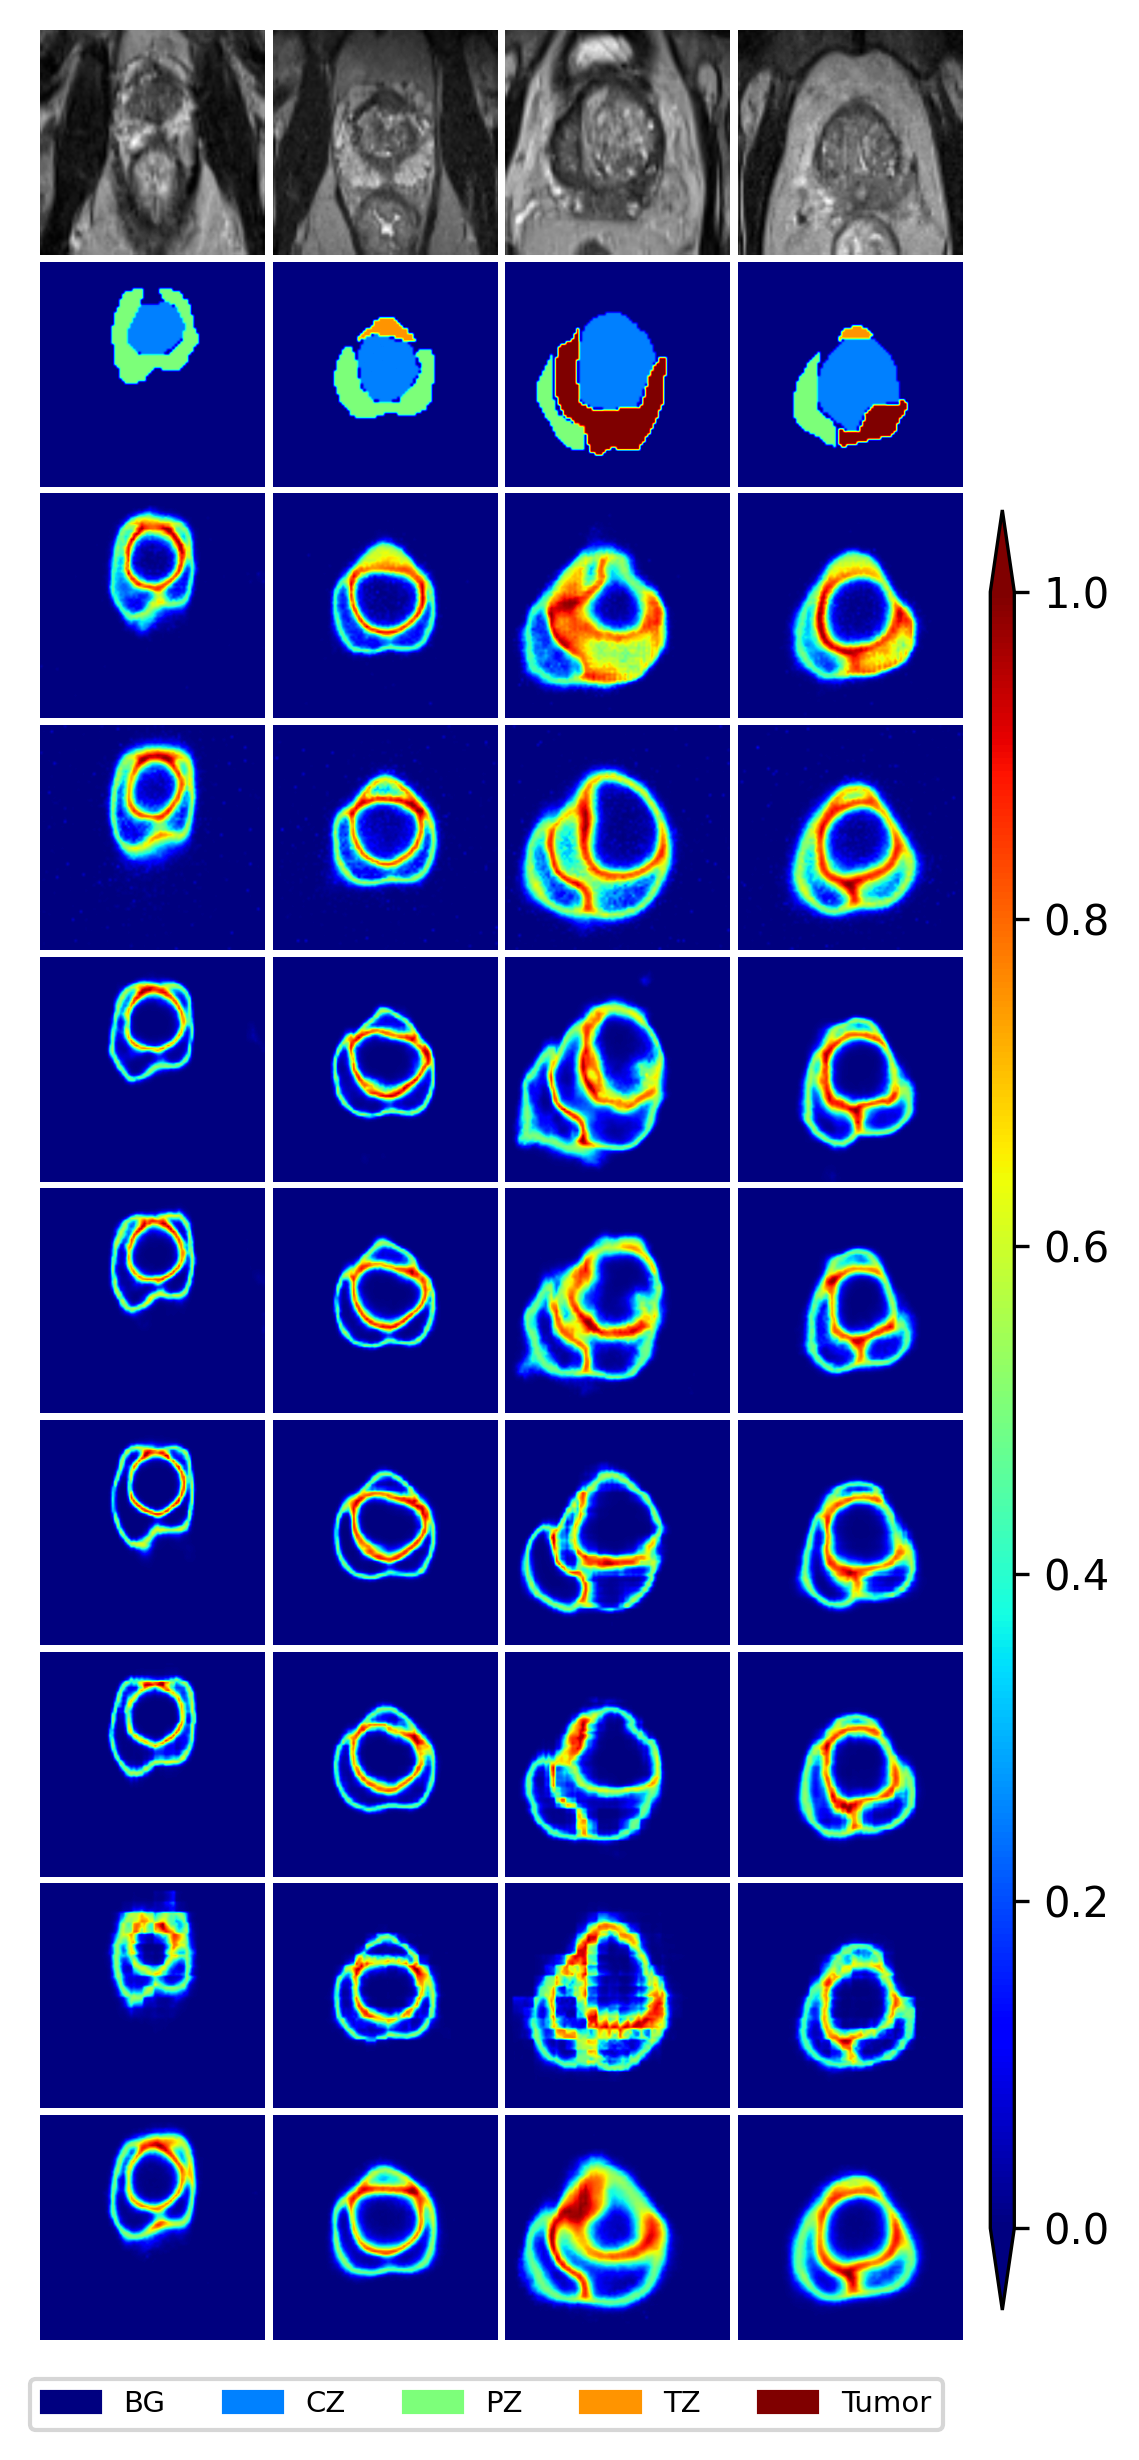

In [12]:
bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dict_entropy['unet']['entropy_all'][z2]

fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(4,10), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[1,0].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[1,0].axis('off')


ax[0,1].imshow(dict_imgs[z3], cmap='gray')
ax[0,1].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[0,2].imshow(dict_imgs[z3t], cmap='gray')
ax[0,2].axis('off')
ax[1,2].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[1,2].axis('off')


ax[0,3].imshow(dict_imgs[z4], cmap='gray')
ax[0,3].axis('off')
im1 = ax[1,3].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[1,3].axis('off')

###############################################


# UNET
ax[2,0].imshow(dict_entropy['unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[2,0].axis('off')
ax[2,1].imshow(dict_entropy['unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[2,1].axis('off')
ax[2,2].imshow(dict_entropy['unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,2].axis('off')
ax[2,3].imshow(dict_entropy['unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[2,3].axis('off')

# Att UNet
ax[3,0].imshow(dict_entropy['attunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[3,0].axis('off')
ax[3,1].imshow(dict_entropy['attunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[3,1].axis('off')
ax[3,2].imshow(dict_entropy['attunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[3,2].axis('off')
ax[3,3].imshow(dict_entropy['attunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,3].axis('off')

# Dense UNet
ax[4,0].imshow(dict_entropy['denseunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[4,0].axis('off')
ax[4,1].imshow(dict_entropy['denseunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[4,1].axis('off')
ax[4,2].imshow(dict_entropy['denseunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[4,2].axis('off')
ax[4,3].imshow(dict_entropy['denseunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[4,3].axis('off')

# Att denseunet
ax[5,0].imshow(dict_entropy['attdenseunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[5,0].axis('off')
ax[5,1].imshow(dict_entropy['attdenseunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[5,1].axis('off')
ax[5,2].imshow(dict_entropy['attdenseunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[5,2].axis('off')
im = ax[5,3].imshow(dict_entropy['attdenseunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[5,3].axis('off')

# R2U-Net 
ax[6,0].imshow(dict_entropy['r2unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[6,0].axis('off')
ax[6,1].imshow(dict_entropy['r2unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[6,1].axis('off')
ax[6,2].imshow(dict_entropy['r2unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[6,2].axis('off')
im = ax[6,3].imshow(dict_entropy['r2unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[6,3].axis('off')

# Att R2U-Net 
ax[7,0].imshow(dict_entropy['attr2unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[7,0].axis('off')
ax[7,1].imshow(dict_entropy['attr2unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[7,1].axis('off')
ax[7,2].imshow(dict_entropy['attr2unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[7,2].axis('off')
im = ax[7,3].imshow(dict_entropy['attr2unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[7,3].axis('off')

# Swinunet
ax[8,0].imshow(dict_entropy['swinunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[8,0].axis('off')
ax[8,1].imshow(dict_entropy['swinunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[8,1].axis('off')
ax[8,2].imshow(dict_entropy['swinunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[8,2].axis('off')
im = ax[8,3].imshow(dict_entropy['swinunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[8,3].axis('off')

# FAUNET
ax[9,0].imshow(dict_entropy['faunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[9,0].axis('off')
ax[9,1].imshow(dict_entropy['faunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[9,1].axis('off')
ax[9,2].imshow(dict_entropy['faunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[9,2].axis('off')
im = ax[9,3].imshow(dict_entropy['faunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[9,3].axis('off')


cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.60])

fig.colorbar(im, cax=cbar_ax, extend='both')
plt.subplots_adjust(wspace=0, hspace=0.03)

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [im1.cmap(im1.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]

clegend_ax = fig.add_axes([0.93, 0.67, 0.05, 0.07])
leg = fig.legend(handles=patches, ncol=5, prop={'size': 7}, loc=8, borderaxespad=0., bbox_to_anchor=(0.5, 0.08) )

clegend_ax.axis('off')


plt.savefig('Uncertainty_comparison/uq.png', bbox_inches='tight')
plt.show()

### Horizontal

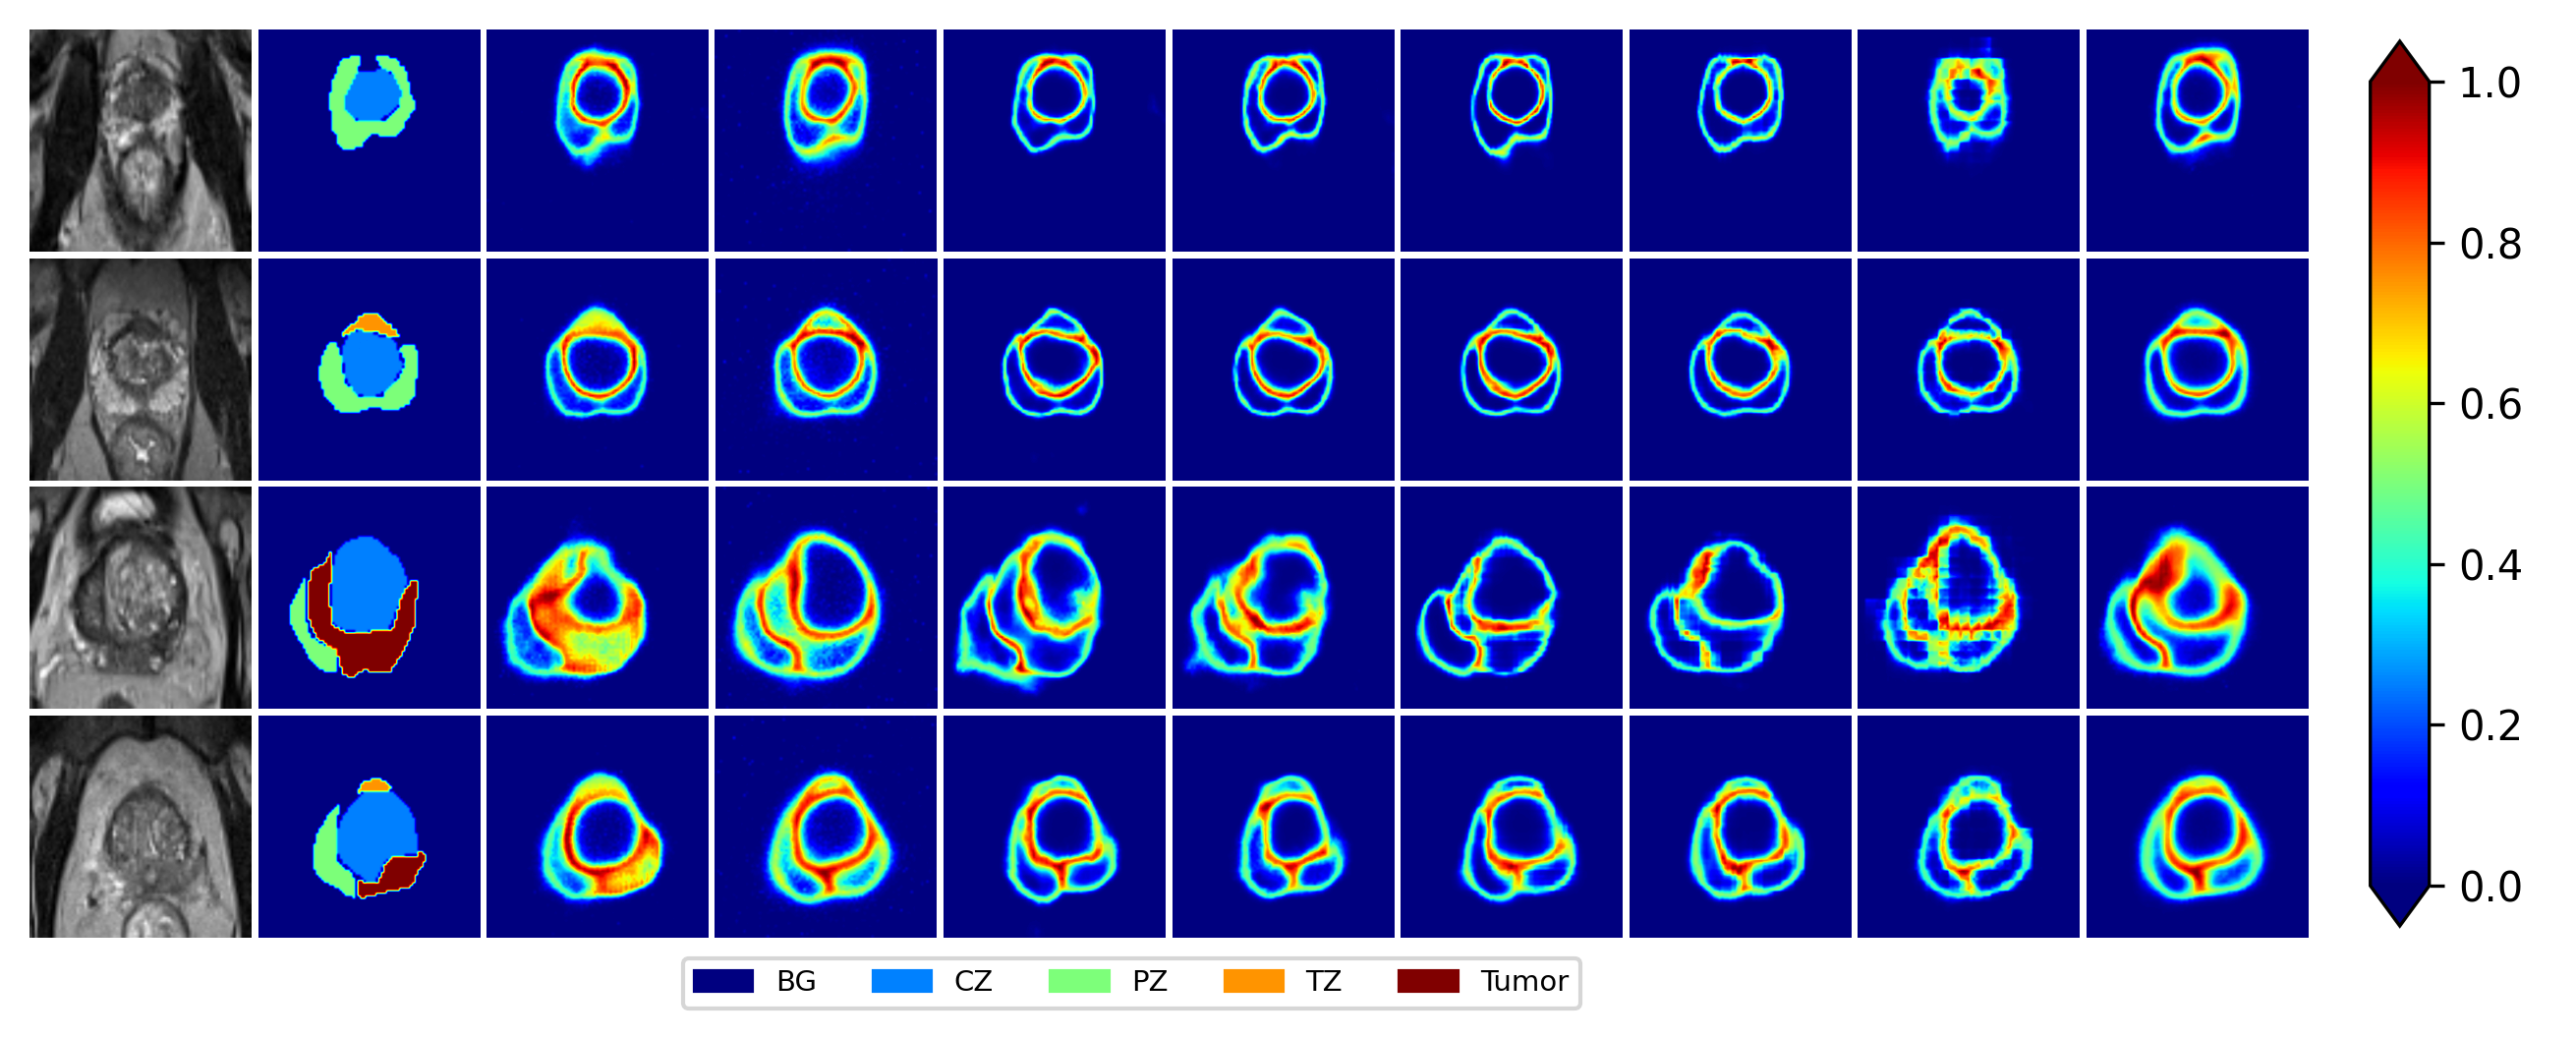

In [20]:
bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

dict_entropy['unet']['entropy_all'][z2]

fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(10,4), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[0,1].axis('off')


ax[1,0].imshow(dict_imgs[z3], cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[2,0].imshow(dict_imgs[z3t], cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[2,1].axis('off')


ax[3,0].imshow(dict_imgs[z4], cmap='gray')
ax[3,0].axis('off')
im1 = ax[3,1].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[3,1].axis('off')

###############################################


# UNET
ax[0,2].imshow(dict_entropy['unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,2].axis('off')
ax[1,2].imshow(dict_entropy['unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,2].axis('off')
ax[2,2].imshow(dict_entropy['unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,2].axis('off')
ax[3,2].imshow(dict_entropy['unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,2].axis('off')

# Att UNet
ax[0,3].imshow(dict_entropy['attunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,3].axis('off')
ax[1,3].imshow(dict_entropy['attunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,3].axis('off')
ax[2,3].imshow(dict_entropy['attunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,3].axis('off')
ax[3,3].imshow(dict_entropy['attunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,3].axis('off')

# Dense UNet
ax[0,4].imshow(dict_entropy['denseunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,4].axis('off')
ax[1,4].imshow(dict_entropy['denseunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,4].axis('off')
ax[2,4].imshow(dict_entropy['denseunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,4].axis('off')
ax[3,4].imshow(dict_entropy['denseunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,4].axis('off')

# Att denseunet
ax[0,5].imshow(dict_entropy['attdenseunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,5].axis('off')
ax[1,5].imshow(dict_entropy['attdenseunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,5].axis('off')
ax[2,5].imshow(dict_entropy['attdenseunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,5].axis('off')
im = ax[3,5].imshow(dict_entropy['attdenseunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,5].axis('off')

# R2U-Net 
ax[0,6].imshow(dict_entropy['r2unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,6].axis('off')
ax[1,6].imshow(dict_entropy['r2unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,6].axis('off')
ax[2,6].imshow(dict_entropy['r2unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,6].axis('off')
im = ax[3,6].imshow(dict_entropy['r2unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,6].axis('off')

# Att R2U-Net 
ax[0,7].imshow(dict_entropy['attr2unet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,7].axis('off')
ax[1,7].imshow(dict_entropy['attr2unet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,7].axis('off')
ax[2,7].imshow(dict_entropy['attr2unet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,7].axis('off')
im = ax[3,7].imshow(dict_entropy['attr2unet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,7].axis('off')

# Swinunet
ax[0,8].imshow(dict_entropy['swinunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,8].axis('off')
ax[1,8].imshow(dict_entropy['swinunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,8].axis('off')
ax[2,8].imshow(dict_entropy['swinunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,8].axis('off')
im = ax[3,8].imshow(dict_entropy['swinunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,8].axis('off')

# FAUNET
ax[0,9].imshow(dict_entropy['faunet']['entropy_all'][z2], vmin=0, vmax=1, cmap='jet')
ax[0,9].axis('off')
ax[1,9].imshow(dict_entropy['faunet']['entropy_all'][z3], vmin=0, vmax=1, cmap='jet')
ax[1,9].axis('off')
ax[2,9].imshow(dict_entropy['faunet']['entropy_all'][z3t], vmin=0, vmax=1, cmap='jet')
ax[2,9].axis('off')
im = ax[3,9].imshow(dict_entropy['faunet']['entropy_all'][z4], vmin=0, vmax=1, cmap='jet')
ax[3,9].axis('off')


cbar_ax = fig.add_axes([0.92, 0.12, 0.02, 0.75])

fig.colorbar(im, cax=cbar_ax, extend='both')
plt.subplots_adjust(wspace=0, hspace=0.03)

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [im1.cmap(im1.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]

clegend_ax = fig.add_axes([0.93, 0.67, 0.05, 0.07])
leg = fig.legend(handles=patches, ncol=5, prop={'size': 7}, loc=8, borderaxespad=0., bbox_to_anchor=(0.5, 0.05) )

clegend_ax.axis('off')


plt.savefig('uq_horizontal.png', bbox_inches='tight')
plt.show()

## Prediction subplot

### Vertical

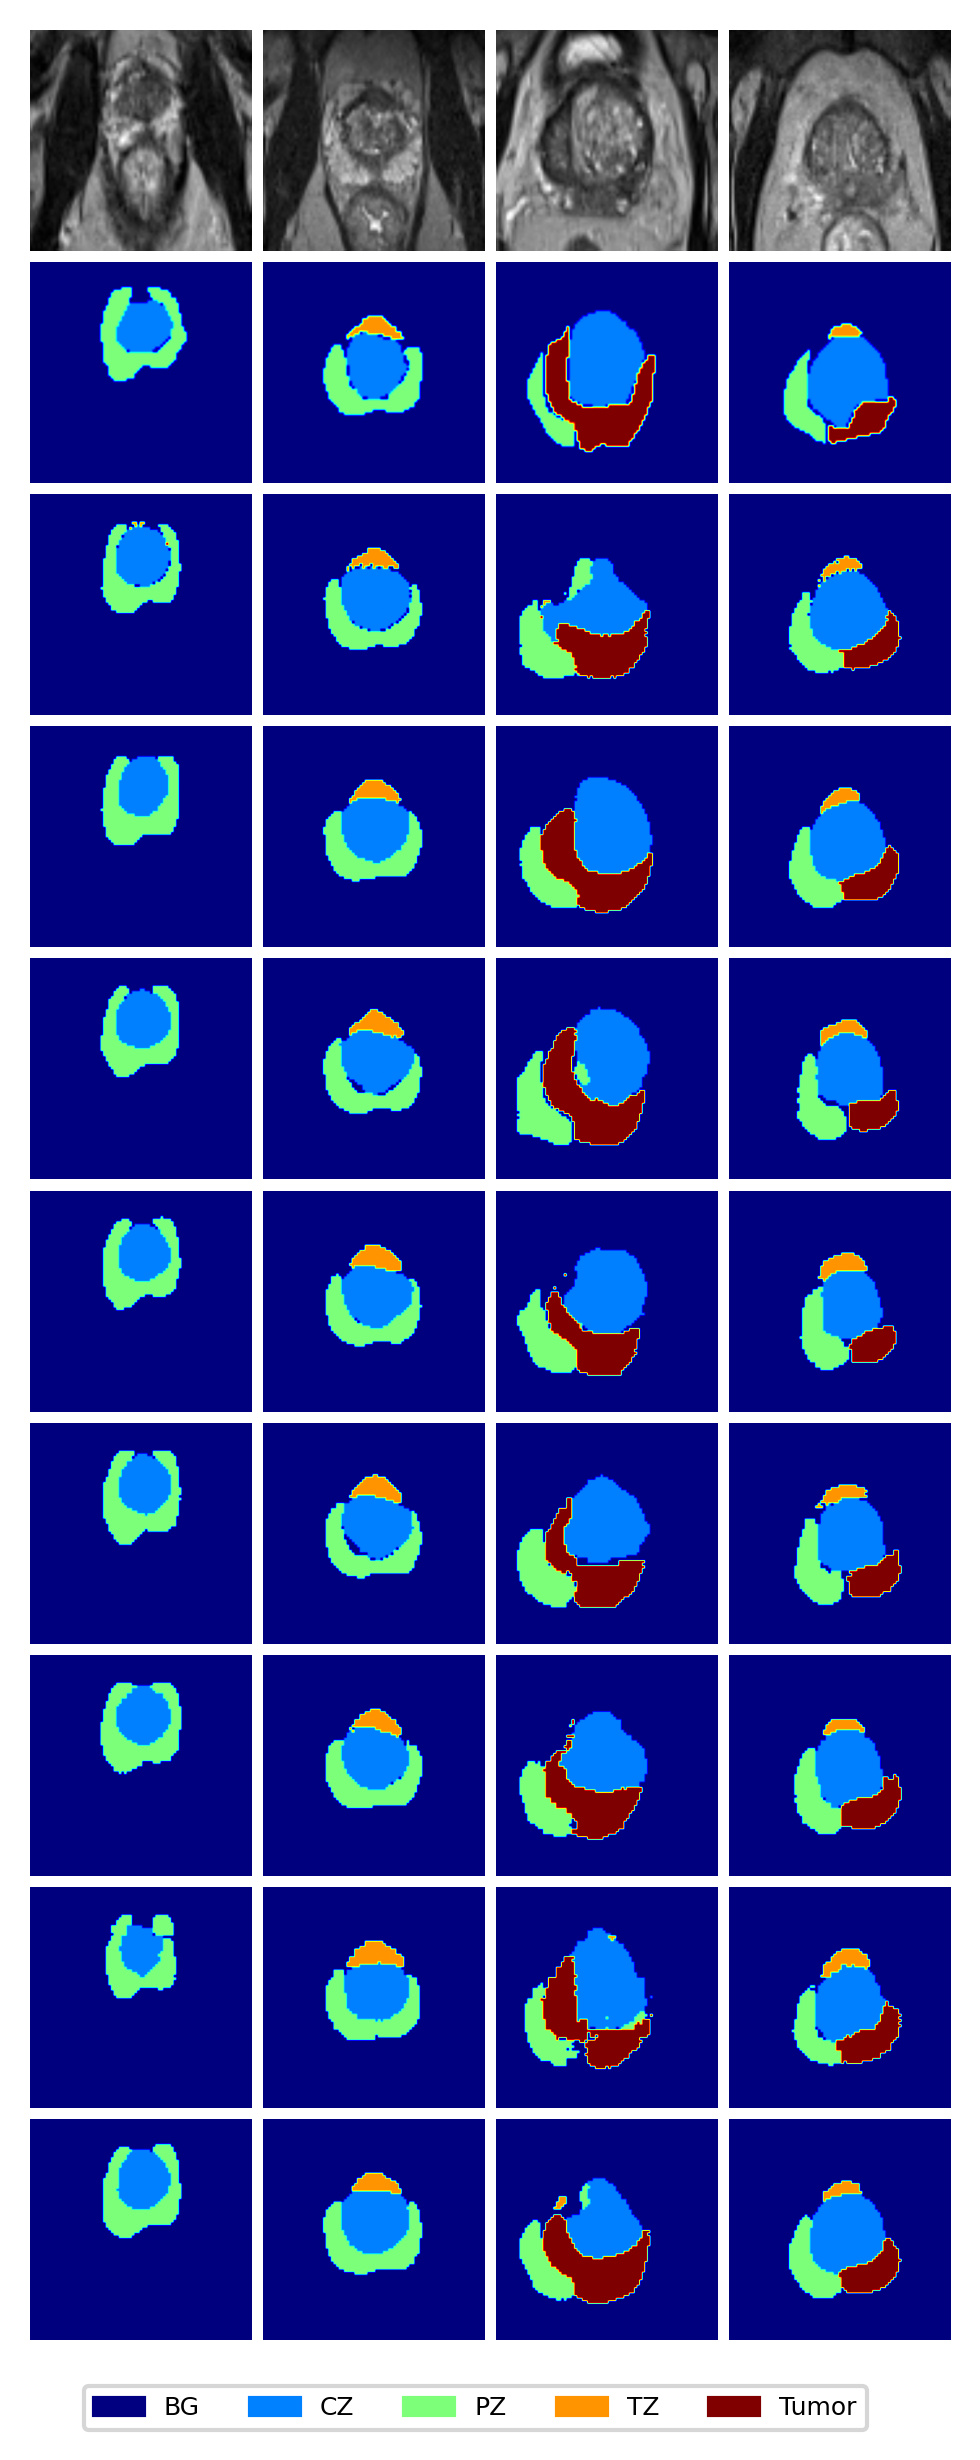

In [22]:

bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=10, ncols=4, figsize=(4,10), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[1,0].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[1,0].axis('off')


ax[0,1].imshow(dict_imgs[z3], cmap='gray')
ax[0,1].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[0,2].imshow(dict_imgs[z3t], cmap='gray')
ax[0,2].axis('off')
ax[1,2].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[1,2].axis('off')


ax[0,3].imshow(dict_imgs[z4], cmap='gray')
ax[0,3].axis('off')
im1 = ax[1,3].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[1,3].axis('off')

###############################################


# UNET
ax[2,0].imshow(dict_preds['unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[2,0].axis('off')
ax[2,1].imshow(dict_preds['unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[2,1].axis('off')
ax[2,2].imshow(dict_preds['unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,2].axis('off')
ax[2,3].imshow(dict_preds['unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[2,3].axis('off')

# Att UNet
ax[3,0].imshow(dict_preds['attunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[3,0].axis('off')
ax[3,1].imshow(dict_preds['attunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[3,1].axis('off')
ax[3,2].imshow(dict_preds['attunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[3,2].axis('off')
ax[3,3].imshow(dict_preds['attunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,3].axis('off')

# Dense UNet
ax[4,0].imshow(dict_preds['denseunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[4,0].axis('off')
ax[4,1].imshow(dict_preds['denseunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[4,1].axis('off')
ax[4,2].imshow(dict_preds['denseunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[4,2].axis('off')
ax[4,3].imshow(dict_preds['denseunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[4,3].axis('off')

# Att denseunet
ax[5,0].imshow(dict_preds['attdenseunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[5,0].axis('off')
ax[5,1].imshow(dict_preds['attdenseunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[5,1].axis('off')
ax[5,2].imshow(dict_preds['attdenseunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[5,2].axis('off')
im = ax[5,3].imshow(dict_preds['attdenseunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[5,3].axis('off')

# R2U-Net 
ax[6,0].imshow(dict_preds['r2unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[6,0].axis('off')
ax[6,1].imshow(dict_preds['r2unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[6,1].axis('off')
ax[6,2].imshow(dict_preds['r2unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[6,2].axis('off')
im = ax[6,3].imshow(dict_preds['r2unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[6,3].axis('off')

# Att R2U-Net 
ax[7,0].imshow(dict_preds['attr2unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[7,0].axis('off')
ax[7,1].imshow(dict_preds['attr2unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[7,1].axis('off')
ax[7,2].imshow(dict_preds['attr2unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[7,2].axis('off')
im = ax[7,3].imshow(dict_preds['attr2unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[7,3].axis('off')

# Swinunet
ax[8,0].imshow(dict_preds['swinunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[8,0].axis('off')
ax[8,1].imshow(dict_preds['swinunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[8,1].axis('off')
ax[8,2].imshow(dict_preds['swinunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[8,2].axis('off')
im = ax[8,3].imshow(dict_preds['swinunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[8,3].axis('off')

# FAUNET
ax[9,0].imshow(dict_preds['faunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[9,0].axis('off')
ax[9,1].imshow(dict_preds['faunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[9,1].axis('off')
ax[9,2].imshow(dict_preds['faunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[9,2].axis('off')
im = ax[9,3].imshow(dict_preds['faunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[9,3].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.05)
# plt.tight_layout()

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
fig.legend(handles=patches, ncol=5, prop={'size': 6}, loc=8, bbox_to_anchor=(0.5, 0.08), borderaxespad=0. )
#plt.savefig('Uncertainty_comparison/preds.png', dpi=300, bbox_inches='tight')
plt.show()



### Horizontal

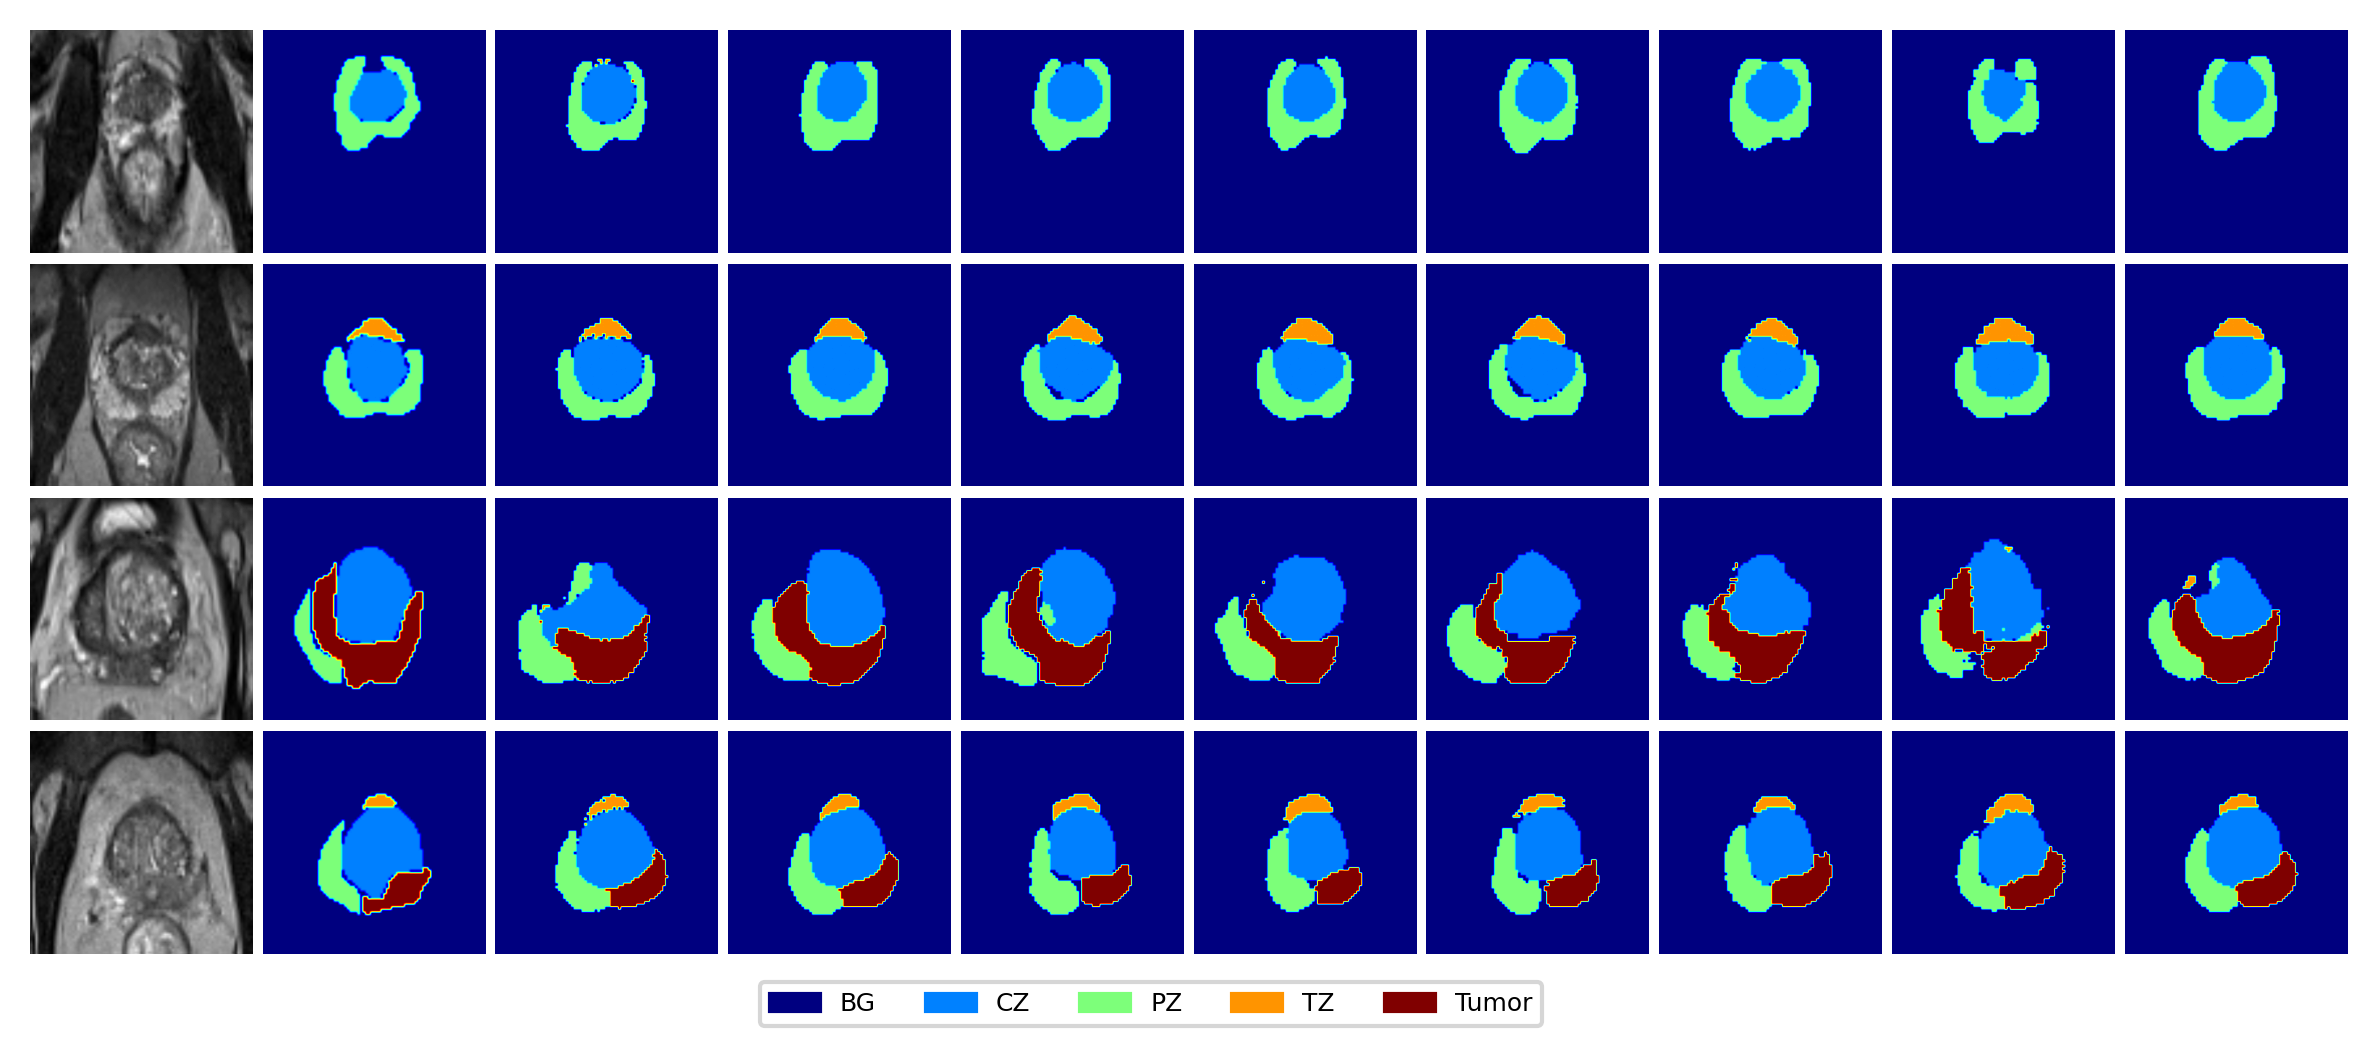

In [23]:

bounds = [0, 1, 2, 3, 4]
colors = ['darkblue', 'deepskyblue', 'brown', 'gold', 'orange']
cmap = mpl.colors.ListedColormap(colors)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


fig, ax = plt.subplots(nrows=4, ncols=10, figsize=(10,4), dpi=300)
ax[0,0].imshow(dict_imgs[z2], cmap='gray')
ax[0,0].axis('off')
ax[0,1].imshow(dict_msks[z2], cmap='jet', vmin=0, vmax=4)
ax[0,1].axis('off')


ax[1,0].imshow(dict_imgs[z3], cmap='gray')
ax[1,0].axis('off')
ax[1,1].imshow(dict_msks[z3], cmap='jet', vmin=0, vmax=4)
ax[1,1].axis('off')


ax[2,0].imshow(dict_imgs[z3t], cmap='gray')
ax[2,0].axis('off')
ax[2,1].imshow(dict_msks[z3t], cmap='jet', vmin=0, vmax=4)
ax[2,1].axis('off')


ax[3,0].imshow(dict_imgs[z4], cmap='gray')
ax[3,0].axis('off')
im1 = ax[3,1].imshow(dict_msks[z4], cmap='jet', vmin=0, vmax=4)
ax[3,1].axis('off')

###############################################


# UNET
ax[0,2].imshow(dict_preds['unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,2].axis('off')
ax[1,2].imshow(dict_preds['unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,2].axis('off')
ax[2,2].imshow(dict_preds['unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,2].axis('off')
ax[3,2].imshow(dict_preds['unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,2].axis('off')

# Att UNet
ax[0,3].imshow(dict_preds['attunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,3].axis('off')
ax[1,3].imshow(dict_preds['attunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,3].axis('off')
ax[2,3].imshow(dict_preds['attunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,3].axis('off')
ax[3,3].imshow(dict_preds['attunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,3].axis('off')

# Dense UNet
ax[0,4].imshow(dict_preds['denseunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,4].axis('off')
ax[1,4].imshow(dict_preds['denseunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,4].axis('off')
ax[2,4].imshow(dict_preds['denseunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,4].axis('off')
ax[3,4].imshow(dict_preds['denseunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,4].axis('off')

# Att denseunet
ax[0,5].imshow(dict_preds['attdenseunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,5].axis('off')
ax[1,5].imshow(dict_preds['attdenseunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,5].axis('off')
ax[2,5].imshow(dict_preds['attdenseunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,5].axis('off')
im = ax[3,5].imshow(dict_preds['attdenseunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,5].axis('off')

# R2U-Net 
ax[0,6].imshow(dict_preds['r2unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,6].axis('off')
ax[1,6].imshow(dict_preds['r2unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,6].axis('off')
ax[2,6].imshow(dict_preds['r2unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,6].axis('off')
im = ax[3,6].imshow(dict_preds['r2unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,6].axis('off')

# Att R2U-Net 
ax[0,7].imshow(dict_preds['attr2unet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,7].axis('off')
ax[1,7].imshow(dict_preds['attr2unet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,7].axis('off')
ax[2,7].imshow(dict_preds['attr2unet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,7].axis('off')
im = ax[3,7].imshow(dict_preds['attr2unet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,7].axis('off')

# Swinunet
ax[0,8].imshow(dict_preds['swinunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,8].axis('off')
ax[1,8].imshow(dict_preds['swinunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,8].axis('off')
ax[2,8].imshow(dict_preds['swinunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,8].axis('off')
im = ax[3,8].imshow(dict_preds['swinunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,8].axis('off')

# FAUNET
ax[0,9].imshow(dict_preds['faunet'][z2], cmap='jet', vmin=0, vmax=4)
ax[0,9].axis('off')
ax[1,9].imshow(dict_preds['faunet'][z3], cmap='jet', vmin=0, vmax=4)
ax[1,9].axis('off')
ax[2,9].imshow(dict_preds['faunet'][z3t], cmap='jet', vmin=0, vmax=4)
ax[2,9].axis('off')
im = ax[3,9].imshow(dict_preds['faunet'][z4], cmap='jet', vmin=0, vmax=4)
ax[3,9].axis('off')

plt.subplots_adjust(wspace=0.01, hspace=0.05)
# plt.tight_layout()

import matplotlib.patches as mpatches
values2 = ['BG','CZ','PZ','TZ','Tumor']
values = [0,1,2,3,4]
colors = [ im.cmap(im.norm(value)) for value in values]
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=values2[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
fig.legend(handles=patches, ncol=5, prop={'size': 6}, loc=8, bbox_to_anchor=(0.5, 0.05), borderaxespad=0. )
plt.savefig('uq_preds_horizontal.png', dpi=300, bbox_inches='tight')
plt.show()



# Boxplot

CZ

In [ ]:
predicted_image = entropy['r2unet']['entropy_cz']
bin_cz = []
for i in range(31):
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_cz.append(bins[1])
# print(values)
bin_cz = np.mean(bin_cz)
bin_cz

In [ ]:
bins

PZ

In [ ]:
predicted_image = entropy['r2unet']['entropy_pz']
bin_pz = []
for i in range(31):
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_pz.append(bins[1])
bin_pz = np.mean(bin_pz)
bin_pz

TZ

In [ ]:
predicted_image = entropy['r2unet']['entropy_tz']
bin_tz = []
lsttz = lst3+lst4
for i in lsttz:
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_tz.append(bins[1])
bin_tz = np.mean(bin_tz)
bin_tz

TUM

In [ ]:
predicted_image = entropy['r2unet']['entropy_tum']
bin_tum = []
lsttum = lst3t+lst4
for i in lsttum:
    plt.figure(figsize=(18,6), dpi=300)
    values, bins, bars = plt.hist(predicted_image[i].flatten(),linewidth=0.1, bins=100)
    labels = plt.bar_label(bars, fontsize=12, color='navy')
    plt.close()
    bin_tum.append(bins[1])
bin_tum = np.mean(bin_tum)
bin_tum

Mean threshold

In [ ]:
avg_bin = np.mean([bin_cz, bin_pz, bin_tz, bin_tum])
avg_bin

In [6]:
import math
def weighted_avg_and_std_arr(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=(1,2))
    # Fast and numerically precise:
    # variance = np.average((values-average)**2, weights=weights)
    return average


In [13]:
import pandas as pd
dict_boxplot = {}
for name in list(entropy.keys()):
    # thres = 0.0005
    thres = 0.000

    arr = []
    arr2 = []
    idx_tz = []
    idx_tum = []
    for i in range(len(entropy[name]['entropy_tz'])):
        if np.max(entropy[name]['entropy_tz'][i]) >= thres:
            arr.append(entropy[name]['entropy_tz'][i])
        else:
            idx_tz.append(i)
            
        if np.max(entropy[name]['entropy_tum'][i]) >= thres:
            arr2.append(entropy[name]['entropy_tum'][i])
        else:
            idx_tum.append(i)

    idx_tz = np.array(idx_tz)        
    idx_tum = np.array(idx_tum)  


    ent_tz_temp = np.array(arr)
    ent_tum_temp = np.array(arr2)
    # Mean Entropy per image and zone
    ent_cz = weighted_avg_and_std_arr(entropy[name]['entropy_cz'], entropy[name]['entropy_cz']>=thres)
    ent_pz = weighted_avg_and_std_arr(entropy[name]['entropy_pz'], entropy[name]['entropy_pz']>=thres)
    ent_tz = weighted_avg_and_std_arr(ent_tz_temp, ent_tz_temp>thres)
    ent_tum = weighted_avg_and_std_arr(ent_tum_temp, ent_tum_temp>thres)
    ent_gland = weighted_avg_and_std_arr(entropy[name]['entropy_gland'], entropy[name]['entropy_gland']>=thres)
    ent_all = weighted_avg_and_std_arr(entropy[name]['entropy_all'], entropy[name]['entropy_all']>=thres)

    ent_tz2 = []
    ent_tum2 = []
    x=0
    y=0
    for i in range(31):
        if i in idx_tz:
            ent_tz2.append(np.NaN)
        else:
            ent_tz2.append(ent_tz[x])
            x+=1
        if i in idx_tum:
            ent_tum2.append(np.NaN)
        else:
            ent_tum2.append(ent_tum[y])
            y+=1
    ent_tz = np.array(ent_tz2)
    ent_tum = np.array(ent_tum2)

    d = ({"all": ent_all, "gland": ent_gland, "cz": ent_cz, "pz": ent_pz, "tz": ent_tz, "tum": ent_tum})
    dict_boxplot[name] = pd.DataFrame(d, index=range(31))
    # dict_boxplot[name].to_csv(name)


In [14]:
import pandas as pd
dict_boxplot = {}
for name in list(entropy.keys()):
    thres = 0

    
    ent_cz = np.mean(dict_entropy[name]['entropy_cz'], axis=(1,2))
    ent_pz = np.mean(dict_entropy[name]['entropy_pz'], axis=(1,2))
    ent_tz = np.mean(dict_entropy[name]['entropy_tz'], axis=(1,2))
    ent_tum = np.mean(dict_entropy[name]['entropy_tum'], axis=(1,2))
    ent_gland = np.mean(dict_entropy[name]['entropy_gland'], axis=(1,2))
    ent_all = np.mean(dict_entropy[name]['entropy_all'], axis=(1,2))
    


    ent_tz2 = []
    ent_tum2 = []
    x=0
    y=0
    for i in range(31):
        if i in idx_tz:
            ent_tz2.append(np.NaN)
        else:
            ent_tz2.append(ent_tz[x])
            x+=1
        if i in idx_tum:
            ent_tum2.append(np.NaN)
        else:
            ent_tum2.append(ent_tum[y])
            y+=1
    ent_tz = np.array(ent_tz2)
    ent_tum = np.array(ent_tum2)

    d = ({"all": ent_all, "gland": ent_gland, "cz": ent_cz, "pz": ent_pz, "tz": ent_tz, "tum": ent_tum})
    dict_boxplot[name] = pd.DataFrame(d, index=range(31))
    # dict_boxplot[name].to_csv(name)
    # print(dict_boxplot)

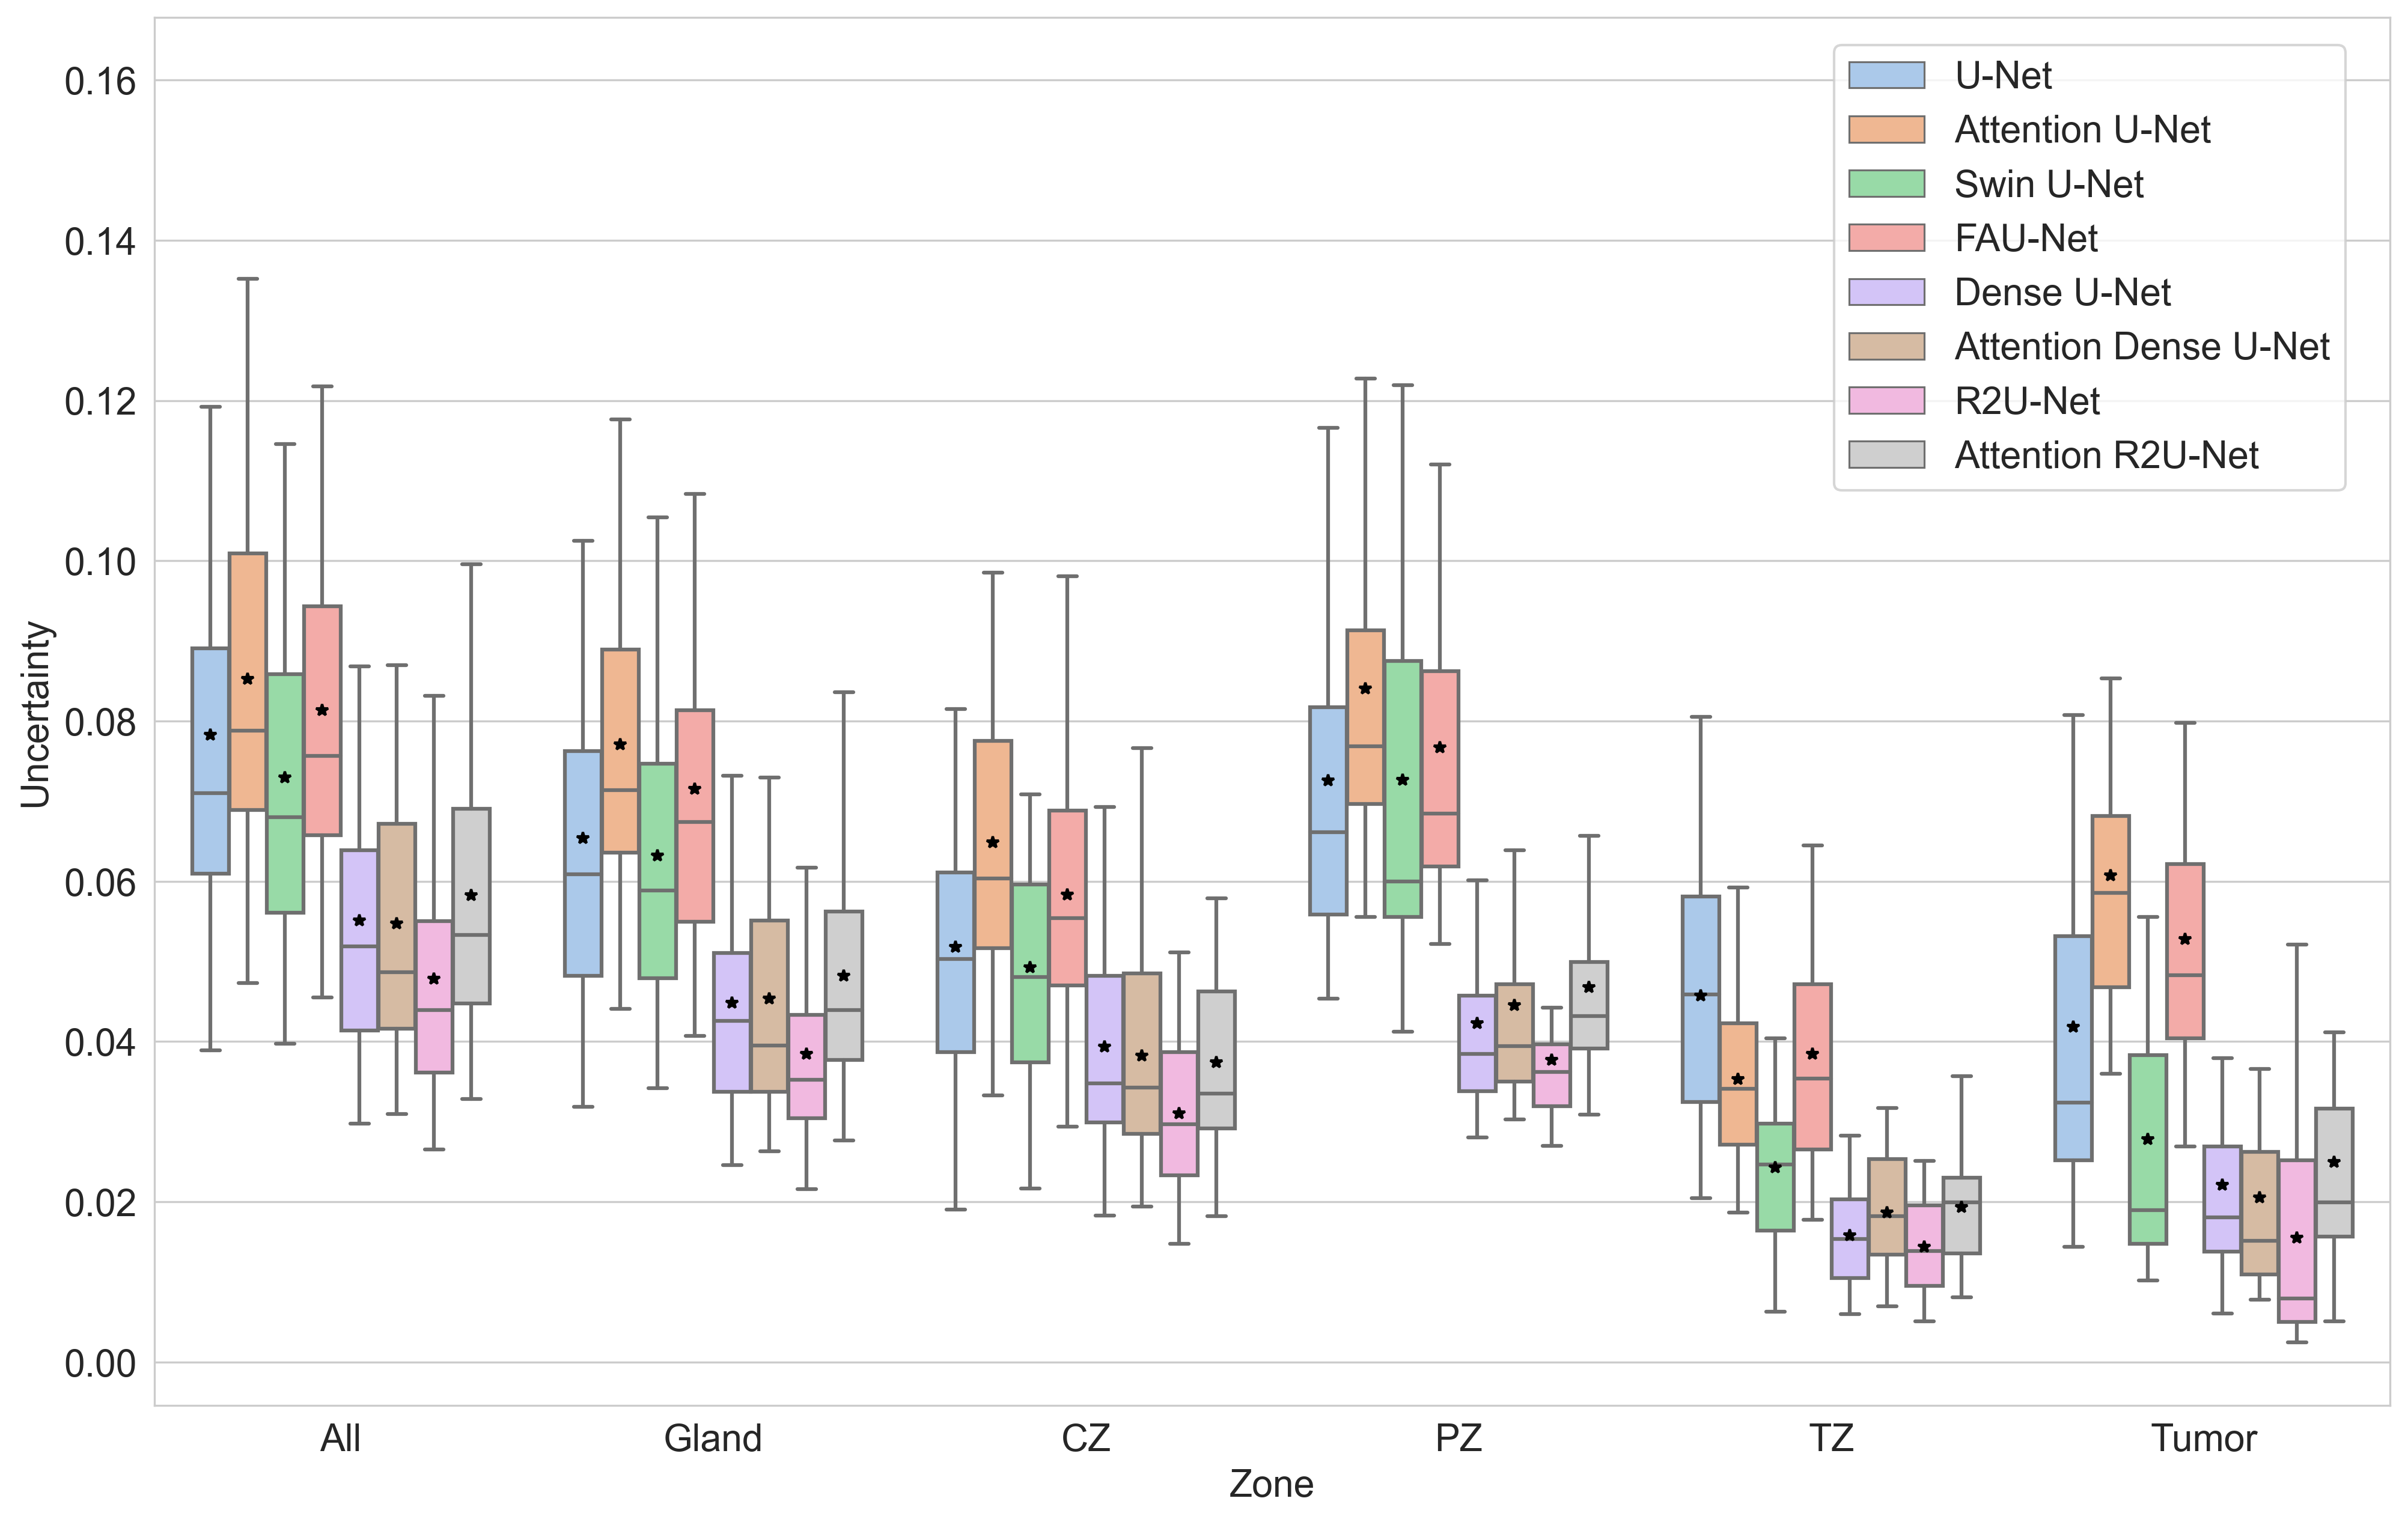

In [20]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)
import pandas as pd
import seaborn as sns


df_unet = dict_boxplot['unet']
df_unet['model'] = 'U-Net'

df_attunet = dict_boxplot['attunet']
df_attunet['model'] = 'Attention U-Net'

df_denseunet = dict_boxplot['denseunet']
df_denseunet['model'] = 'Dense U-Net'

df_attdenseunet = dict_boxplot['attdenseunet']
df_attdenseunet['model'] = 'Attention Dense U-Net'

df_r2unet = dict_boxplot['r2unet']
df_r2unet['model'] = 'R2U-Net'

df_attr2unet = dict_boxplot['attr2unet']
df_attr2unet['model'] = 'Attention R2U-Net'

df_swinunet = dict_boxplot['swinunet']
df_swinunet['model'] = 'Swin U-Net'

df_faunet = dict_boxplot['faunet']
df_faunet['model'] = 'FAU-Net'


cdf = pd.concat([df_unet, df_attunet, df_swinunet, df_faunet, df_denseunet, df_attdenseunet, df_r2unet, df_attr2unet])
cdf = cdf.rename(columns={'all': 'All', 'gland': 'Gland', 'cz': 'CZ', 'pz': 'PZ', 'tz': 'TZ', 'tum': 'Tumor'})
cdf_without_all = cdf.drop('All', axis=1)
cdf_only_all = cdf[['All', 'model']]

mdf_without_all = pd.melt(cdf_without_all, id_vars=['model'], var_name=['Zone'])
mdf_without_all = mdf_without_all.rename(columns={'value': 'Uncertainty', 'model': 'Model'})

mdf_only_all = pd.melt(cdf_only_all, id_vars=['model'], var_name=['Zone'])
mdf_only_all = mdf_only_all.rename(columns={'value': 'Uncertainty', 'model': 'Model'})

mdf = pd.melt(cdf, id_vars=['model'], var_name=['Zone'])
mdf = mdf.rename(columns={'value': 'Uncertainty', 'model': 'Model'})

plt.rcParams['font.size'] = 15
plt.figure(figsize=[16,10],dpi=300)
sns.set_style("whitegrid")

# ax_1 = sns.stripplot(x='Zone', y='Uncertainty', hue='Model', data=mdf, size=3, jitter=0.15, dodge= True, 
#               linewidth=0.5,edgecolor='gray', palette='pastel')
ax_2 = sns.boxplot(x="Zone", y="Uncertainty", hue="Model", data=mdf, fliersize= 0,
                 palette='pastel', showmeans=True, meanprops={"marker": "*",
                       "markeredgecolor": "black",
                       "markersize": "5",
                       "markerfacecolor": 'black'})

handles, labels = ax_2.get_legend_handles_labels()
l = ax_2.legend(handles[0:8], labels[0:8], bbox_to_anchor=(0.98, 0.98), loc='upper right', borderaxespad=0.)
# ax_2.set_ylim(0, 0.02)

plt.savefig('uq_boxplot.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [16]:
mdf

,Model,Zone,Uncertainty
0,U-Net,All,0.038870
1,U-Net,All,0.066146
2,U-Net,All,0.084370
3,U-Net,All,0.109222
4,U-Net,All,0.081804
...,...,...,...
1483,Attention R2U-Net,Tumor,0.019917
1484,Attention R2U-Net,Tumor,0.031535
1485,Attention R2U-Net,Tumor,0.014602
1486,Attention R2U-Net,Tumor,0.058219


In [290]:
meandf = pd.DataFrame({'UNet':df_unet.mean(numeric_only=True),
            'Attention UNet': df_attunet.mean(numeric_only=True),
            'Dense UNet': df_denseunet.mean(numeric_only=True),
            'Attention Dense UNet': df_attdenseunet.mean(numeric_only=True),
            'R2U-Net': df_r2unet.mean(numeric_only=True),
            'Attention R2U-Net': df_attr2unet.mean(numeric_only=True),
            'Swin U-Net': df_swinunet.mean(numeric_only=True),
            'FAU-Net': df_faunet.mean(numeric_only=True),
            })
meandf.style.highlight_min(color = 'lightgreen', 
                       axis = 1).highlight_max(color = 'red', axis=1)


,UNet,Attention UNet,Dense UNet,Attention Dense UNet,R2U-Net,Attention R2U-Net,Swin U-Net,FAU-Net
all,0.078262,0.085282,0.055122,0.054757,0.047851,0.058268,0.072929,0.081368
gland,0.065407,0.077089,0.044847,0.045383,0.038458,0.048193,0.063169,0.071507
cz,0.051831,0.064833,0.039375,0.038205,0.031048,0.037411,0.049229,0.058330
pz,0.072594,0.084035,0.042303,0.044538,0.037744,0.046808,0.072681,0.076727
tz,0.045765,0.035279,0.015826,0.018657,0.014402,0.019301,0.024311,0.038461
tum,0.041814,0.060724,0.022142,0.020524,0.015476,0.024983,0.027805,0.052806


In [22]:
std_unet = df_unet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_attunet = df_attunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_denseunet = df_denseunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_attdenseunet = df_attdenseunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_r2unet = df_r2unet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_attr2unet = df_attr2unet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_swinunet = df_swinunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)
std_faunet = df_faunet[['all', 'gland', 'cz', 'pz', 'tz', 'tum']].std(ddof=0)


meandf = pd.DataFrame({'UNet':df_unet.mean(numeric_only=True),
            'Std UNet': std_unet,
            'Attention UNet': df_attunet.mean(numeric_only=True),
            'Std Attention UNet': std_attunet,
            'Dense UNet': df_denseunet.mean(numeric_only=True),
            'Std Dense UNet': std_denseunet,
            'Attention Dense UNet': df_attdenseunet.mean(numeric_only=True),
            'Std Attention Dense UNet': std_attdenseunet,
            'R2U-Net': df_r2unet.mean(numeric_only=True),
            'Std R2U-Net': std_r2unet,
            'Attention R2U-Net': df_attr2unet.mean(numeric_only=True),
            'Std Attention R2U-Net': std_attr2unet,
            'Swin U-Net': df_swinunet.mean(numeric_only=True),
            'Std Swin U-Net': std_swinunet,
            'FAU-Net': df_faunet.mean(numeric_only=True),
            'Std FAU-Net': std_faunet,
            })

meandf
# print(meandf.to_latex())

,UNet,Std UNet,Attention UNet,Std Attention UNet,Dense UNet,Std Dense UNet,Attention Dense UNet,Std Attention Dense UNet,R2U-Net,Std R2U-Net,Attention R2U-Net,Std Attention R2U-Net,Swin U-Net,Std Swin U-Net,FAU-Net,Std FAU-Net
all,0.110011,0.050235,0.025418,0.007482,0.008699,0.003486,0.008489,0.003367,0.066596,0.025234,0.062925,0.032262,0.010516,0.003589,0.100616,0.025154
gland,0.008496,0.003267,0.010008,0.002802,0.004550,0.001816,0.004745,0.001886,0.003708,0.001302,0.004638,0.001537,0.006745,0.002519,0.008576,0.003164
cz,0.002127,0.000871,0.002979,0.000723,0.001630,0.000614,0.001604,0.000518,0.001260,0.000417,0.001521,0.000510,0.001997,0.000677,0.002383,0.000693
pz,0.002962,0.000904,0.003775,0.000821,0.001773,0.000556,0.001834,0.000622,0.001537,0.000442,0.001917,0.000521,0.002962,0.001039,0.003155,0.000818
tz,0.002145,0.000806,0.001431,0.000565,0.000555,0.000369,0.000665,0.000409,0.000496,0.000357,0.000881,0.000587,0.000942,0.000447,0.002183,0.001026
tum,0.001857,0.001256,0.001839,0.001053,0.000592,0.000716,0.000642,0.000744,0.000603,0.000880,0.000972,0.001293,0.000844,0.000958,0.002598,0.001686
